In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss), (1 - pt)**gamma
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    #original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)
    alpha=0.25
    gamma=2.0
    targets = labels.squeeze(1).float()
    BCE_loss = F.binary_cross_entropy_with_logits(student_outputs[:,1,:,:], targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    modulating_number = torch.mean((1 - pt)**gamma)
    F_loss = at * modulating_number * BCE_loss
    #print("modulating_number = ", modulating_number)
    # mean
    original_loss = torch.mean(F_loss)
    #print("original loss = ", original_loss)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))
    #print("distillation loss = ", distillation_loss)
    
    # total loss
    #total_loss = modulating_number*((1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss)
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss*modulating_number
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0616/weights_KD_segformer_0616_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0604(nn.Module):
    def __init__(self,num_classes,backbone="b0",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}
        # 在conda 環境裡huggingface包好的Segformer有改(modeling_segformer.py)

# Student Model: Segformer 0601
backbone = "b0"
num_classes = 2
model_segformer = MySegFormer_0604(num_classes, backbone)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should pro

FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10
1/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 0.0894

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 506ms/step - loss: 0.0656
Average validation loss: 0.6236681938171387
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 517ms/step - loss: 0.0656 - val_loss: 0.6237
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_0\segformer_data_size_5.pth'.
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 497ms/step - loss: 0.0457 - val_loss: 0.6237
Average validation loss: 0.5484133958816528
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 510ms/step - loss: 0.0457 - val_loss: 0.5860
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_0\segformer_data_size_5.pth'.
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 519ms/step - loss: 0.0339 - val_loss: 0.5860
Average validation loss: 0.5597431659698486
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 533ms/step - loss: 0.0339 - val_loss: 0.5773
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 505ms/step - loss: 0.0265 - val_loss: 0.5773
Average validation loss: 0.546740

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 806ms/step - loss: 3.3376e-05
Average validation loss: 0.032879963517189026
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 817ms/step - loss: 3.3376e-05 - val_loss: 0.0329
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_0\segformer_data_size_10.pth'.
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 777ms/step - loss: 2.9608e-05 - val_loss: 0.0329
Average validation loss: 0.051547812297940254
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 791ms/step - loss: 2.9608e-05 - val_loss: 0.0422
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 799ms/step - loss: 2.6793e-05 - val_loss: 0.0422
Average validation loss: 0.06199559569358826
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 809ms/step - loss: 2.6793e-05 - val_loss: 0.0488
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 25s 767ms/step - loss: 2.5518e-05 - val_loss: 0.0488
Average validation loss: 0.0994054526090622
8/8 ━━━━━━━━━━━━━━━━━━━━ 25s 781ms/step - loss: 2.5518e-05 - val_loss: 0.0615
Epoch 5/10
8/8 ━━━━━━━━━━━━

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 798ms/step - loss: 7.3250e-06
Average validation loss: 0.024456293011705082
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 809ms/step - loss: 7.3250e-06 - val_loss: 0.0245
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_0\segformer_data_size_15.pth'.
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 766ms/step - loss: 2.3649e-05 - val_loss: 0.0245
Average validation loss: 0.13484597206115723
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 782ms/step - loss: 2.3649e-05 - val_loss: 0.0797
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 28s 772ms/step - loss: 1.9709e-05 - val_loss: 0.0797
Average validation loss: 0.045067584762970604
12/12 ━━━━━━━━━━━━━━━━━━━━ 28s 786ms/step - loss: 1.9709e-05 - val_loss: 0.0681
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 38s 773ms/step - loss: 1.7191e-05 - val_loss: 0.0681
Average validation loss: 0.03038747360308965
12/12 ━━━━━━━━━━━━━━━━━━━━ 38s 789ms/step - loss: 1.7191e-05 - val_loss: 0.0587
Epoch 5/1

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 805ms/step - loss: 7.3804e-06
Average validation loss: 0.01042621408123523
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 816ms/step - loss: 7.3804e-06 - val_loss: 0.0104
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_0\segformer_data_size_20.pth'.
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 25s 776ms/step - loss: 6.3628e-06 - val_loss: 0.0104
Average validation loss: 0.10019002109766006
16/16 ━━━━━━━━━━━━━━━━━━━━ 26s 789ms/step - loss: 6.3628e-06 - val_loss: 0.0553
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 785ms/step - loss: 5.6259e-06 - val_loss: 0.0553
Average validation loss: 0.008809936814941466
16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 798ms/step - loss: 5.6259e-06 - val_loss: 0.0398
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_0\segformer_data_size_20.pth'.
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 51s 780ms/step - loss: 5.1018e-

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 885ms/step - loss: 5.7059e-06
Average validation loss: 0.01050050426274538
20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 895ms/step - loss: 5.7059e-06 - val_loss: 0.0105
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_0\segformer_data_size_25.pth'.
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 34s 797ms/step - loss: 4.2704e-06 - val_loss: 0.0105
Average validation loss: 0.0074707577005028725
20/20 ━━━━━━━━━━━━━━━━━━━━ 34s 810ms/step - loss: 4.2704e-06 - val_loss: 0.0090
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_0\segformer_data_size_25.pth'.
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 49s 762ms/step - loss: 3.5424e-06 - val_loss: 0.0090
Average validation loss: 0.003938638558611274
20/20 ━━━━━━━━━━━━━━━━━━━━ 50s 776ms/step - loss: 3.5424e-06 - val_loss: 0.0073
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\we

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 18s 768ms/step - loss: 3.3559e-06
Average validation loss: 0.015814954570184152
24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 781ms/step - loss: 3.3559e-06 - val_loss: 0.0158
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_0\segformer_data_size_30.pth'.
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 37s 769ms/step - loss: 2.6741e-06 - val_loss: 0.0158
Average validation loss: 0.005670261530516048
24/24 ━━━━━━━━━━━━━━━━━━━━ 38s 782ms/step - loss: 2.6741e-06 - val_loss: 0.0107
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_0\segformer_data_size_30.pth'.
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 56s 770ms/step - loss: 2.2343e-06 - val_loss: 0.0107
Average validation loss: 0.0035164294337543347
24/24 ━━━━━━━━━━━━━━━━━━━━ 56s 783ms/step - loss: 2.2343e-06 - val_loss: 0.0083
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\w

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 33s 816ms/step - loss: 6.7618e-06
Average validation loss: 0.12040442246943713
40/40 ━━━━━━━━━━━━━━━━━━━━ 33s 828ms/step - loss: 6.7618e-06 - val_loss: 0.1204
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_0\segformer_data_size_50.pth'.
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 67s 862ms/step - loss: 5.1599e-06 - val_loss: 0.1204
Average validation loss: 0.020951199112460017
40/40 ━━━━━━━━━━━━━━━━━━━━ 68s 874ms/step - loss: 5.1599e-06 - val_loss: 0.0707
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_0\segformer_data_size_50.pth'.
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 100s 812ms/step - loss: 4.5815e-06 - val_loss: 0.0707
Average validation loss: 0.0561582377878949
40/40 ━━━━━━━━━━━━━━━━━━━━ 101s 826ms/step - loss: 4.5815e-06 - val_loss: 0.0658
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 133s 807ms/step - loss: 3.9914

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 ━━━━━━━━━━━━━━━━━━━━ 39s 817ms/step - loss: 5.4665e-06
Average validation loss: 0.017039279104210436
48/48 ━━━━━━━━━━━━━━━━━━━━ 40s 829ms/step - loss: 5.4665e-06 - val_loss: 0.0170
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_0\segformer_data_size_60.pth'.
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 78s 796ms/step - loss: 4.7031e-06 - val_loss: 0.0170
Average validation loss: 0.0353602278434361
48/48 ━━━━━━━━━━━━━━━━━━━━ 79s 806ms/step - loss: 4.7031e-06 - val_loss: 0.0262
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 117s 800ms/step - loss: 3.9500e-06 - val_loss: 0.0262
Average validation loss: 0.07715316504860918
48/48 ━━━━━━━━━━━━━━━━━━━━ 118s 811ms/step - loss: 3.9500e-06 - val_loss: 0.0432
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 156s 809ms/step - loss: 3.4692e-06 - val_loss: 0.0432
Average validation loss: 0.12589881150051951
48/48 ━━━━━━━━━━━━━━━━━━━━ 157s 820ms/step - loss: 3.4692e-06 - val_loss: 0.0639
Epoch 

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 ━━━━━━━━━━━━━━━━━━━━ 48s 864ms/step - loss: 3.1257e-06
Average validation loss: 0.04173105735597866
56/56 ━━━━━━━━━━━━━━━━━━━━ 49s 876ms/step - loss: 3.1257e-06 - val_loss: 0.0417
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_0\segformer_data_size_70.pth'.
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 100s 910ms/step - loss: 2.4646e-06 - val_loss: 0.0417
Average validation loss: 0.0036620905365063144
56/56 ━━━━━━━━━━━━━━━━━━━━ 101s 922ms/step - loss: 2.4646e-06 - val_loss: 0.0227
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_0\segformer_data_size_70.pth'.
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 148s 848ms/step - loss: 2.0087e-06 - val_loss: 0.0227
Average validation loss: 0.004911305952451325
56/56 ━━━━━━━━━━━━━━━━━━━━ 149s 860ms/step - loss: 2.0087e-06 - val_loss: 0.0168
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 195s 817ms/step - loss: 1

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 ━━━━━━━━━━━━━━━━━━━━ 49s 770ms/step - loss: 1.7291e-06
Average validation loss: 0.005241023238340858
64/64 ━━━━━━━━━━━━━━━━━━━━ 50s 782ms/step - loss: 1.7291e-06 - val_loss: 0.0052
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_0\segformer_data_size_80.pth'.
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 101s 801ms/step - loss: 1.2827e-06 - val_loss: 0.0052
Average validation loss: 0.01149856930715032
64/64 ━━━━━━━━━━━━━━━━━━━━ 102s 813ms/step - loss: 1.2827e-06 - val_loss: 0.0084
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 153s 797ms/step - loss: 1.1722e-06 - val_loss: 0.0084
Average validation loss: 0.0039191100222524256
64/64 ━━━━━━━━━━━━━━━━━━━━ 154s 809ms/step - loss: 1.1722e-06 - val_loss: 0.0069
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_0\segformer_data_size_80.pth'.
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 208s 850ms/step - loss: 1

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 56s 784ms/step - loss: 2.3365e-06
Average validation loss: 0.0030555804583450984
72/72 ━━━━━━━━━━━━━━━━━━━━ 57s 796ms/step - loss: 2.3365e-06 - val_loss: 0.0031
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_0\segformer_data_size_90.pth'.
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 114s 783ms/step - loss: 1.6852e-06 - val_loss: 0.0031
Average validation loss: 0.0028567196309773456
72/72 ━━━━━━━━━━━━━━━━━━━━ 114s 795ms/step - loss: 1.6852e-06 - val_loss: 0.0030
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_0\segformer_data_size_90.pth'.
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 173s 814ms/step - loss: 1.3264e-06 - val_loss: 0.0030
Average validation loss: 0.0028599927706333497
72/72 ━━━━━━━━━━━━━━━━━━━━ 174s 825ms/step - loss: 1.3264e-06 - val_loss: 0.0029
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 231s 791ms/step - loss

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 ━━━━━━━━━━━━━━━━━━━━ 64s 802ms/step - loss: 1.3474e-06
Average validation loss: 0.009977168549085036
80/80 ━━━━━━━━━━━━━━━━━━━━ 65s 814ms/step - loss: 1.3474e-06 - val_loss: 0.0100
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_0\segformer_data_size_100.pth'.
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 130s 811ms/step - loss: 9.2153e-07 - val_loss: 0.0100
Average validation loss: 0.0033208857814315705
80/80 ━━━━━━━━━━━━━━━━━━━━ 131s 822ms/step - loss: 9.2153e-07 - val_loss: 0.0066
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_0\segformer_data_size_100.pth'.
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 194s 792ms/step - loss: 7.1547e-07 - val_loss: 0.0066
Average validation loss: 0.0024315791728440673
80/80 ━━━━━━━━━━━━━━━━━━━━ 195s 804ms/step - loss: 7.1547e-07 - val_loss: 0.0052
Saved model weights to 'c:\天_11157065\git\RipplesDetection\

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 ━━━━━━━━━━━━━━━━━━━━ 83s 868ms/step - loss: 1.7774e-05
Average validation loss: 0.023605354285488527
96/96 ━━━━━━━━━━━━━━━━━━━━ 84s 880ms/step - loss: 1.7774e-05 - val_loss: 0.0236
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_0\segformer_data_size_120.pth'.
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 164s 832ms/step - loss: 1.4221e-05 - val_loss: 0.0236
Average validation loss: 0.0426898526881511
96/96 ━━━━━━━━━━━━━━━━━━━━ 165s 844ms/step - loss: 1.4221e-05 - val_loss: 0.0331
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 242s 803ms/step - loss: 1.0544e-05 - val_loss: 0.0331
Average validation loss: 0.006955877994187176
96/96 ━━━━━━━━━━━━━━━━━━━━ 243s 814ms/step - loss: 1.0544e-05 - val_loss: 0.0244
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_0\segformer_data_size_120.pth'.
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 318s 775ms/step - loss: 8

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 ━━━━━━━━━━━━━━━━━━━━ 99s 828ms/step - loss: 8.4137e-06
Average validation loss: 0.020323608893280228
120/120 ━━━━━━━━━━━━━━━━━━━━ 101s 839ms/step - loss: 8.4137e-06 - val_loss: 0.0203
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_0\segformer_data_size_150.pth'.
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 202s 848ms/step - loss: 5.9360e-06 - val_loss: 0.0203
Average validation loss: 0.005577177988986174
120/120 ━━━━━━━━━━━━━━━━━━━━ 204s 860ms/step - loss: 5.9360e-06 - val_loss: 0.0130
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_0\segformer_data_size_150.pth'.
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 307s 862ms/step - loss: 4.2916e-06 - val_loss: 0.0130
Average validation loss: 0.004851108341244981
120/120 ━━━━━━━━━━━━━━━━━━━━ 309s 874ms/step - loss: 4.2916e-06 - val_loss: 0.0103
Saved model weights to 'c:\天_11157065\git\Ripple

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 ━━━━━━━━━━━━━━━━━━━━ 114s 788ms/step - loss: 6.1762e-06
Average validation loss: 0.04118876409443652
144/144 ━━━━━━━━━━━━━━━━━━━━ 115s 800ms/step - loss: 6.1762e-06 - val_loss: 0.0412
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_0\segformer_data_size_180.pth'.
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 234s 822ms/step - loss: 4.0940e-06 - val_loss: 0.0412
Average validation loss: 0.050634101769699354
144/144 ━━━━━━━━━━━━━━━━━━━━ 235s 834ms/step - loss: 4.0940e-06 - val_loss: 0.0459
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 349s 787ms/step - loss: 3.1489e-06 - val_loss: 0.0459
Average validation loss: 0.0338639122265805
144/144 ━━━━━━━━━━━━━━━━━━━━ 350s 798ms/step - loss: 3.1489e-06 - val_loss: 0.0419
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_0\segformer_data_size_180.pth'.
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 467s 810ms

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 ━━━━━━━━━━━━━━━━━━━━ 132s 823ms/step - loss: 6.3110e-06
Average validation loss: 0.01978091577284431
160/160 ━━━━━━━━━━━━━━━━━━━━ 133s 835ms/step - loss: 6.3110e-06 - val_loss: 0.0198
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_0\segformer_data_size_200.pth'.
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 260s 794ms/step - loss: 4.0968e-06 - val_loss: 0.0198
Average validation loss: 0.006826837676635477
160/160 ━━━━━━━━━━━━━━━━━━━━ 262s 805ms/step - loss: 4.0968e-06 - val_loss: 0.0133
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_0\segformer_data_size_200.pth'.
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 386s 773ms/step - loss: 3.0877e-06 - val_loss: 0.0133
Average validation loss: 0.005837765010801377
160/160 ━━━━━━━━━━━━━━━━━━━━ 388s 784ms/step - loss: 3.0877e-06 - val_loss: 0.0108
Saved model weights to 'c:\天_11157065\git\Ripple

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 ━━━━━━━━━━━━━━━━━━━━ 157s 787ms/step - loss: 4.0216e-06
Average validation loss: 0.009069080767157517
200/200 ━━━━━━━━━━━━━━━━━━━━ 160s 799ms/step - loss: 4.0216e-06 - val_loss: 0.0091
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_0\segformer_data_size_250.pth'.
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 327s 833ms/step - loss: 3.7772e-06 - val_loss: 0.0091
Average validation loss: 0.03968297998527717
200/200 ━━━━━━━━━━━━━━━━━━━━ 329s 845ms/step - loss: 3.7772e-06 - val_loss: 0.0244
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 499s 848ms/step - loss: 3.5002e-06 - val_loss: 0.0244
Average validation loss: 0.005556084460695274
200/200 ━━━━━━━━━━━━━━━━━━━━ 501s 859ms/step - loss: 3.5002e-06 - val_loss: 0.0181
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_0\segformer_data_size_250.pth'.
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 679s 892

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 ━━━━━━━━━━━━━━━━━━━━ 198s 823ms/step - loss: 3.5738e-06
Average validation loss: 0.006164901870700608
240/240 ━━━━━━━━━━━━━━━━━━━━ 200s 834ms/step - loss: 3.5738e-06 - val_loss: 0.0062
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_0\segformer_data_size_300.pth'.
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 392s 797ms/step - loss: 2.5578e-06 - val_loss: 0.0062
Average validation loss: 0.0055632776644718735
240/240 ━━━━━━━━━━━━━━━━━━━━ 394s 808ms/step - loss: 2.5578e-06 - val_loss: 0.0059
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_0\segformer_data_size_300.pth'.
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 584s 792ms/step - loss: 2.3545e-06 - val_loss: 0.0059
Average validation loss: 0.007850539210873345
240/240 ━━━━━━━━━━━━━━━━━━━━ 587s 803ms/step - loss: 2.3545e-06 - val_loss: 0.0065
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 793s 8

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.13968512944877148, 0.03725133250001818, 0.022859135942223174, 0.010879454159585293, 0.014722099964972585, 0.010312877013736092, 0.07117034799989778, 0.03322111375697811, 0.03176834652690949, 0.009290765559780994, 0.006656113115022891, 0.004548825296660652, 0.006803777093785659, 0.04116788005699606, 0.044411970263579334, 0.050486494770620595, 0.011463850184031068, 0.00820934075444572]
std_val_losses =  [0.14238374765254688, 0.03187218424364814, 0.0247697493522994, 0.01377492656488033, 0.03215569077148362, 0.015889830223668334, 0.10306729089967927, 0.04459634875752294, 0.04763281980476688, 0.01566532438678426, 0.011668419850143096, 0.004650885331965781, 0.0074049265996031805, 0.06957901528611406, 0.05800321157350624, 0.04334061500850985, 0.009184181694704904, 0.005761948393462076]


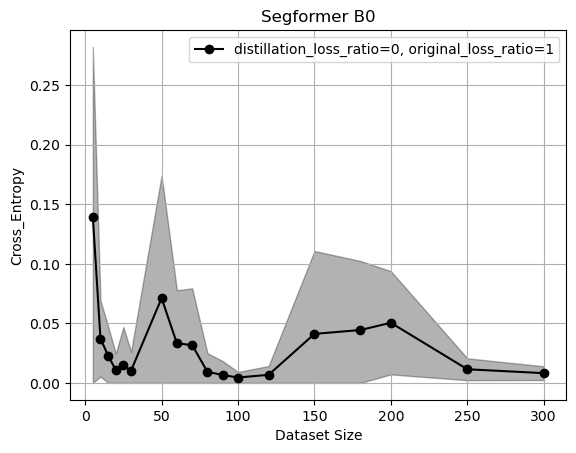

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0616')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0616_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0616_{int(teacher_ratio*100)}.png"))

plt.show()